# Plot RomyControl Statistics

## Import Libraries

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import obspy
import numpy as np

## Configurations

In [2]:
path_to_file = f"/import/freenas-ffb-01-data/romy_archive/2022/BW/CROMY/"
filename = "romy_control.log"

## Load Data

In [3]:
df = pd.read_csv(path_to_file+filename, names=['timestamp', 'comment'])

## Processing

In [4]:
mlti = df[df.comment.str.contains("ACTION", na=False)]
mlti.reset_index(drop=True, inplace=True)
mlti = mlti.assign(date = mlti.timestamp.str.split("T").str[0])
mlti = mlti.assign(time = mlti.timestamp.str.split("T").str[1])

mlti['num'] = np.ones(len(mlti))

In [5]:
actions = mlti.groupby(['date'])['num'].sum().reset_index()

In [6]:
from obspy import UTCDateTime

tdist = mlti

## calculate differences in MLTI times
tt = [UTCDateTime(str(t)) for t in mlti.timestamp]
tdist['time_diff'] = np.diff(tt, prepend=tt[0])
tdist

## remove super large values
max_time_to_next_mlti = 1e6
tdist['time_diff'].where(tdist['time_diff'] <= max_time_to_next_mlti, np.nan, inplace=True)


,timestamp,comment,date,time,num,time_diff
0,2021-12-16T18:30:34.051341,ACTION: inciated MLTI due to low AC value!,2021-12-16,18:30:34.051341,1.0,0
1,2021-12-17T12:37:08.863364,ACTION: inciated MLTI due to low AC value!,2021-12-17,12:37:08.863364,1.0,65194.8
2,2021-12-18T01:23:01.984495,ACTION: inciated MLTI due to low AC value!,2021-12-18,01:23:01.984495,1.0,45953.1
3,2021-12-18T04:21:21.184703,ACTION: inciated MLTI due to low AC value!,2021-12-18,04:21:21.184703,1.0,10699.2
4,2021-12-18T13:25:58.827577,ACTION: inciated MLTI due to low AC value!,2021-12-18,13:25:58.827577,1.0,32677.6
...,...,...,...,...,...,...
1054,2022-02-02T06:53:13.333212,ACTION: inciated MLTI due to low AC value!,2022-02-02,06:53:13.333212,1.0,60.0374
1055,2022-02-02T06:54:17.800317,ACTION: inciated MLTI due to low AC value!,2022-02-02,06:54:17.800317,1.0,64.4671
1056,2022-02-02T06:55:18.346231,ACTION: inciated MLTI due to low AC value!,2022-02-02,06:55:18.346231,1.0,60.5459
1057,2022-02-03T08:48:34.877379,ACTION: inciated MLTI due to low AC value!,2022-02-03,08:48:34.877379,1.0,93196.5


## Plotting

In [7]:
def __makeplot_bar(config):
    
    '''
    Config: 
        - xdata
        - ydata
        - xth
        - ylabel
        - title
        
    '''
    
    
    # Creating histogram
    fig, ax = plt.subplots(1, 1, figsize =(12, 5), tight_layout = True)

    NN = len(config['xdata'])

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6, zorder=0)


    # Creating histogram
    bars = range(0, NN)
    ax.bar(bars, config['ydata'], width=0.8, align='center', alpha=0.9)


    # Set ticks
    datelabel = config['xdata'][::config['xth']]
    dateticks = bars[::config['xth']]

    ax.set_xticklabels(datelabel)
    ax.set_xticks(dateticks)


    # Adding extra features   
    plt.ylabel(config['ylabel'])
    plt.title(config['title'])
              
    # Show plot
    plt.show();

    return fig

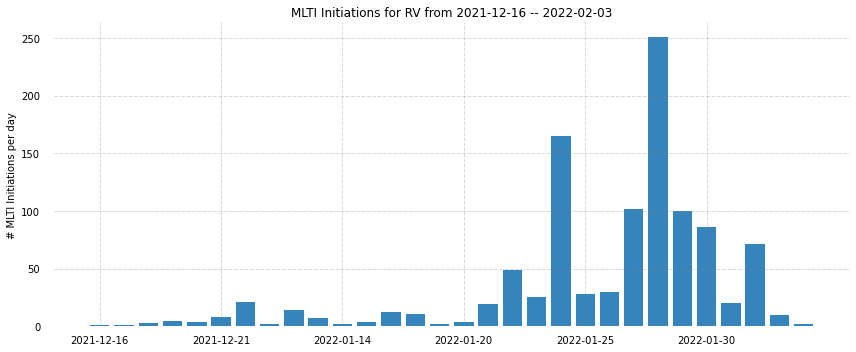

In [8]:
conf = {}

conf['xdata'] = actions.date
conf['ydata'] = actions.num
conf['ring'] = "RV"
conf['title'] = f"MLTI Initiations for {conf['ring']} from {actions.date.iloc[0]} -- {actions.date.iloc[-1]}"
conf['ylabel'] = "# MLTI Initiations per day"
conf['xth'] = 5


__makeplot_bar(conf);

In [9]:
def __makeplot_histogram(config):
    
    '''
    Config: 
        - ydata
        - bars
        - xth
        - ylabel
        - title
        - xlogscale
        - ylogscale
        
    '''
    
    
    # Creating histogram
    fig, ax = plt.subplots(1, 1, figsize =(12, 5), tight_layout = True)

#     NN = len(config['xdata'])

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.6, zorder=0)


    # Creating histogram
    if config['xlogscale']:
        config['bins'] = 10 ** np.linspace(np.log10(60), np.log10(max(config['ydata'])), config['bins'])
        ax.set_xscale('log')
    if config['ylogscale']:
        ax.set_yscale('log')
        
    ax.hist(config['ydata'], bins=config['bins'], rwidth=0.8, align='left', alpha=0.9);


    # Adding extra features   
    plt.ylabel(config['ylabel'])
    plt.xlabel(config['xlabel'])
    plt.title(config['title'])
              
    # Show plot
    plt.show();

    return fig

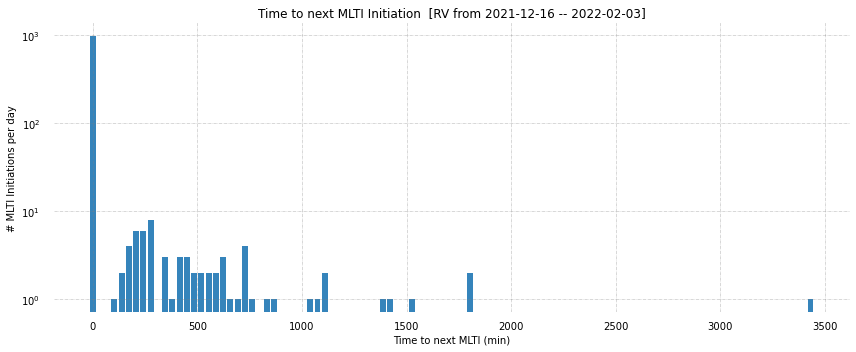

In [10]:
conf = {}

conf['xdata'] = None
conf['bins']  = 100
conf['xlogscale'] = False
conf['ylogscale'] = True
conf['ydata'] = tdist['time_diff']/60
conf['ring'] = "RV"
conf['title'] = f"Time to next MLTI Initiation  [{conf['ring']} from {actions.date.iloc[0]} -- {actions.date.iloc[-1]}]"
conf['ylabel'] = "# MLTI Initiations per day"
conf['xlabel'] = "Time to next MLTI (min)"

__makeplot_histogram(conf);

In [11]:
def __makeplot_timeline(config):
    
    '''
    Config: 
        - ydata
        - bars
        - xth
        - ylabel
        - title
        - xlogscale
        - ylogscale
        
    '''
    
    
    # Creating histogram
    fig, ax = plt.subplots(1, 1, figsize =(12, 5), tight_layout = True)

#     NN = len(config['xdata'])

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.6, zorder=0)


    # Creating histogram
    if config['xlogscale']:
        ax.set_xscale('log')
    if config['ylogscale']:
        ax.set_yscale('log')
        
    ax.plot(range(0,len(config['ydata'])), config['ydata'],'o', markersize=1.5)


    # Adding extra features   
    plt.ylabel(config['ylabel'])
    plt.xlabel(config['xlabel'])
    plt.title(config['title'])
              
    # Show plot
    plt.show();

    return fig

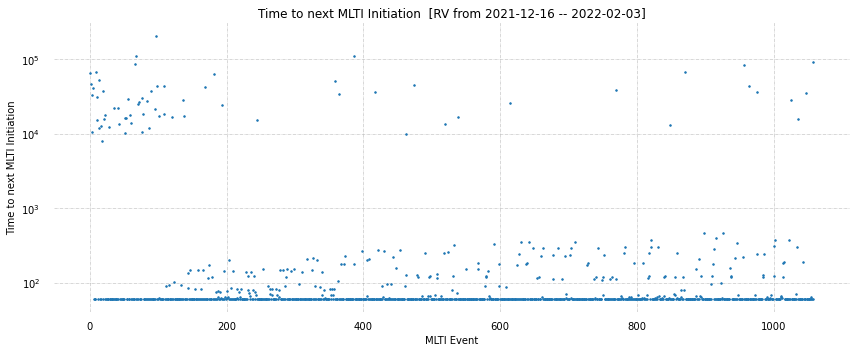

In [12]:
conf = {}

conf['xdata'] = None
conf['bins']  = 50
conf['xlogscale'] = False
conf['ylogscale'] = True
conf['ydata'] = tdist['time_diff']
conf['ring'] = "RV"
conf['title'] = f"Time to next MLTI Initiation  [{conf['ring']} from {actions.date.iloc[0]} -- {actions.date.iloc[-1]}]"
conf['ylabel'] = "Time to next MLTI Initiation"
conf['xlabel'] = "MLTI Event"

__makeplot_timeline(conf);